In [8]:
# The computation time for the translation part is really long, so we did it and save the new version
# of our dataframe in a csv in which we are going to work.

import pandas as pd
from googletrans import Translator # pip install googletrans==3.1.0a0
from tqdm import tqdm

# Importing the dataframe
# df = pd.read_csv('data_tweet_sample_challenge.csv')  
  
# =============================================================================
# Translate the tweets in English
# =============================================================================
# tr = Translator()

# Creating a progression bar
# progress_bar = tqdm(total=len(df), desc="Translation Progress")

# for i, row in df.iterrows():
    #if row["label"] != "en":
        #translated_text = tr.translate(row["text"], dest='en').text
        #df.at[i, "text"] = translated_text

    # Updating the progression bar
    #progress_bar.update(1)

#progress_bar.close()

# Saving in a csv file
#csv_file_path = 'clean_data_tweet_sample.csv'
#df.to_csv(csv_file_path, index=False)

In [14]:
import numpy as np
import re
import nltk.corpus 
from nltk.corpus import stopwords
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from typing import List, Tuple
from PIL import Image
from tqdm.notebook import tqdm
import ast
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

warnings.filterwarnings("ignore")
nltk.download('stopwords')
tqdm.pandas()

# Importing the dataframe
df = pd.read_csv('clean_data_tweet_sample.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ziedk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Extracting the hashtags and links

In [4]:
def extract_tags(text:str)->dict(): 
    """
    Extract the links and hashtags from each tweet and delete them from each tweet
    """
    d = {}
    try:
        tags = re.findall(r'#\w+',text)
        d['hash_tags'] = tags
    except: 
        d['hash_tags'] = []
    try:
        d['links'] = re.findall(r'(https://t.co/\w+|http://t.co/\w+)',text)
        for link in d['links']:
            text = text.replace(link,'')
    except:
        d['links'] = []
    
    try:
        for tag in tags:
            text = text.replace(tag,'')
        text = text.strip()
        d['text'] = text
    except:
        d['text'] = text
    
    return d
    

def clean_text_col(df):
    """
    Store the links and hashtags of each tweet in two new distinct columns
    """
    text = list()
    links = list()
    tags = list()
    d_clean = dict()
    for r in range(0,len(df)):
        text.append(extract_tags(df['text'][r])['text'])
        tags.append(extract_tags(df['text'][r])['hash_tags'])
        links.append(extract_tags(df['text'][r])['links'])
    
    df['links'] = links
    df['hash_tags'] = tags        
    return df 

df = clean_text_col(df)

# Cleaning the data

In [5]:
stop = stopwords.words('english')
stop.append('rt')

def cleaning(text):
    text = text.lower() # putting the text in lowercase
    text = re.sub("\[.*?\]","",text) # Remove text enclosed in square brackets
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    # remove @, non-alphanumeric chars, tabs, url, rt and http
    text = " ".join([word for word in text.split() if word not in (stop)]) # remove stopwords
    return text

df['text'] = df['text'].apply(lambda x: cleaning(x))

df = df.drop_duplicates('text') # drop the duplicates

# Selecting only the columns that we interested in
selected_columns = ['id', 'created_at', 'text', 'author.name', 'label', 'public_metrics.like_count', 'public_metrics.retweet_count', 'links', 'hash_tags']
df = df.loc[:, selected_columns]
df = df.reset_index(inplace = False)

# Data visualisation

In [6]:
# Create a new column with the date in format: YYYY-MM
df['date_M'] = df['created_at'].apply(lambda x: x[:7])

fig = px.line(df.groupby('date_M').count(), 
              y=df.groupby('date_M').count()['author.name'].values, 
              x=df.groupby('date_M').count().index)
fig.update_layout(plot_bgcolor = "white")
fig.update_layout(
    title="Number of Tweets per months",
    xaxis_title="",
    yaxis_title="Number of Tweets",
    font=dict(
         size=12,
        color="Black"
    ),
    plot_bgcolor = "white"
)
fig.show()

In [7]:
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'en'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'en'].groupby('date_M').count()['author.name'].values,
            name='England'),
    row=1, col=1
)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'fr'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'fr'].groupby('date_M').count()['author.name'].values,
            name='France'),
    row=1, col=2
)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'it'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'it'].groupby('date_M').count()['author.name'].values,
            name='Italy'),
    row=1, col=3
)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'es'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'es'].groupby('date_M').count()['author.name'].values,
            name='Spain'),
    row=2, col=1
)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'de'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'de'].groupby('date_M').count()['author.name'].values,
            name='Germany'),
    row=2, col=2
)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'nl'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'nl'].groupby('date_M').count()['author.name'].values,
            name='Netherlands'),
    row=2, col=3
)

fig.update_layout(height=600, width=800, title_text="Number of Tweets per months")
fig.show()

c:\Users\Jason\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\Jason\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\Jason\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\Jason\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Li

In [8]:
# Number of tweets per author
fig = px.bar(df.groupby('author.name').count().sort_values(by='id', ascending=False).head(20), 
              y=df.groupby('author.name').count().sort_values(by='id', ascending=False).head(20)['id'].values, 
              x=df.groupby('author.name').count().sort_values(by='id', ascending=False).head(20).index)
fig.update_layout(plot_bgcolor = "white")
fig.update_layout(
    title="Number of Tweets per author (top 20)",
    xaxis_title="",
    yaxis_title="Number of Tweets",
    font=dict(
         size=12,
        color="Black"
    ),
    plot_bgcolor = "white"
)
fig.show()

In [16]:
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'en'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'en'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='England'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'fr'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'fr'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='France'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'it'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'it'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='Italy'),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'es'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'es'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='Spain'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'de'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'de'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='Germany'),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'nl'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'nl'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='Netherlands'),
    row=2, col=3
)

fig.update_layout(height=600, width=800, title_text="Number of Tweets per author (top 5)")
fig.write_image('data/tweets_per_author.png')
fig.show()

In [10]:
# Number of likes per author
fig = px.bar(df.groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(20), 
              y=df.groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(20).values, 
              x=df.groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(20).index)
fig.update_layout(plot_bgcolor = "white")
fig.update_layout(
    title="Total number of likes per author (top 20)",
    xaxis_title="",
    yaxis_title="Total number of likes",
    font=dict(
         size=12,
        color="Black"
    ),
    plot_bgcolor = "white"
)
fig.show()

In [17]:
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'en'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'en'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='England'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'fr'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'fr'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='France'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'it'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'it'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='Italy'),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'es'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'es'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='Spain'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'de'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'de'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='Germany'),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'nl'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'nl'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='Netherlands'),
    row=2, col=3
)

fig.update_layout(height=600, width=800, title_text="Total number of likes per author (top 5)")
fig.show()

In [12]:
# Total retweets per author
fig = px.bar(df.groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(20), 
              y=df.groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(20).values, 
              x=df.groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(20).index)
fig.update_layout(plot_bgcolor = "white")
fig.update_layout(
    title="Total number of retweets per author (top 20)",
    xaxis_title="",
    yaxis_title="Total number of retweets",
    font=dict(
         size=12,
        color="Black"
    ),
    plot_bgcolor = "white"
)
fig.show()

In [18]:
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'en'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'en'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='England'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'fr'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'fr'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='France'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'it'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'it'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='Italy'),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'es'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'es'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='Spain'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'de'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'de'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='Germany'),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'nl'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'nl'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='Netherlands'),
    row=2, col=3
)

fig.update_layout(height=600, width=800, title_text="Total number of retweets per author (top 5)")
fig.show()

# Named Entity Recognition

In [14]:
tqdm.pandas()
pipe = pipeline("token-classification", model="autoevaluate/entity-extraction")

# Extract in the dict the keys and values that we interested in
def extract_entity_info(entities):
    return [{'entity': entity['entity'], 'score': entity['score'], 'word': entity['word']} for entity in entities]

# Apply the function in the dataset
df['Entity_recognition'] = df['text'].progress_apply(lambda x: extract_entity_info(pipe(x)))


# Plot the 5 most frequent entities by type of entity
import pandas as pd
import matplotlib.pyplot as plt

# Filter the entities : keep only 'LOC', 'ORG', et 'PER' and a score > 0.90
filtered_entities = df[df['Entity_recognition'].apply(
    lambda x: any(entity['entity'] in ['B-LOC', 'I-LOC', 'B-ORG', 'I-ORG'] and entity['score'] > 0.85 for entity in x)
)]

# Count the frequence by entities
categories = {'LOC': [], 'ORG': []}
word_count = {category: {} for category in categories}
for entities in filtered_entities['Entity_recognition']:
    for entity in entities:
        entity_type = entity['entity']
        if entity_type in ['B-LOC', 'I-LOC', 'B-ORG', 'I-ORG']:
            category = entity_type[2:]  # Delete the B- and I-
            word = entity['word']
            if word not in word_count[category]:
                word_count[category][word] = 1
            else:
                word_count[category][word] += 1

100%|██████████| 2917/2917 [02:26<00:00, 19.89it/s]


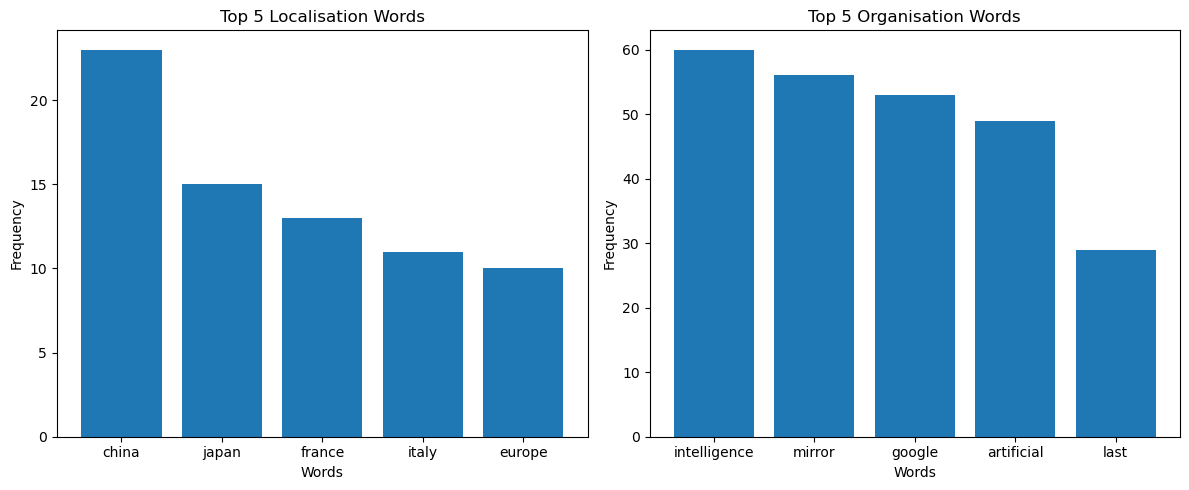

In [15]:
# Plot the 5 most frequent for the localisation
cleaned_dict_loc = {key.lstrip('#'): value for key, value in word_count['LOC'].items()}

# Data Filtering
filtered_dict_loc = {key: value for key, value in cleaned_dict_loc.items() if len(key) > 3}
sorted_dict_loc = dict(sorted(filtered_dict_loc.items(), key=lambda item: item[1], reverse=True)[:5])

# Plot the 5 most frequent for the organisation
cleaned_dict_org = {key.lstrip('#'): value for key, value in word_count['ORG'].items()}

# Data Filtering
filtered_dict_org = {key: value for key, value in cleaned_dict_org.items() if len(key) > 3}
sorted_dict_org = dict(sorted(filtered_dict_org.items(), key=lambda item: item[1], reverse=True)[:5])

# Create a new figure with subplots
plt.figure(figsize=(12, 5))

# Subplot for the Localisation
plt.subplot(1, 2, 1)
plt.bar(sorted_dict_loc.keys(), sorted_dict_loc.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 5 Localisation Words')

# Subplot for the Organisation
plt.subplot(1, 2, 2)
plt.bar(sorted_dict_org.keys(), sorted_dict_org.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 5 Organisation Words')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

# Sentiment Analysis

In [9]:
# Call the classifier pipeline from huggingFace
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)
df = pd.read_csv('sentiment_df.csv')

def find_sentiment(tweet):
    """
    Extract the sentiment from each tweet with the highest score
    """
    score = 0
    sentiment =''
    model_outputs = classifier(tweet)
    #print(model_outputs)
    for i in model_outputs[0]:
        if (i['score'] > score):
            score = i['score']
            sentiment = i['label']
    return {'label':sentiment,'score':score}
        
    
def extract_sentiment_df(df):
    """
    Store each sentiment in a column with the score
    """
    sentiment = list()
    for i in range(0,len(df)):
        sentiment.append(find_sentiment(df['text'][i]))
    df['sentiment'] = sentiment
    return df 

df_sentiment = extract_sentiment_df(df)


"""
Store the new dataframes in a csv file
"""
#csv_file_path = 'sentiment_df.csv'
#df.to_csv(csv_file_path, index=False)


KeyboardInterrupt: 

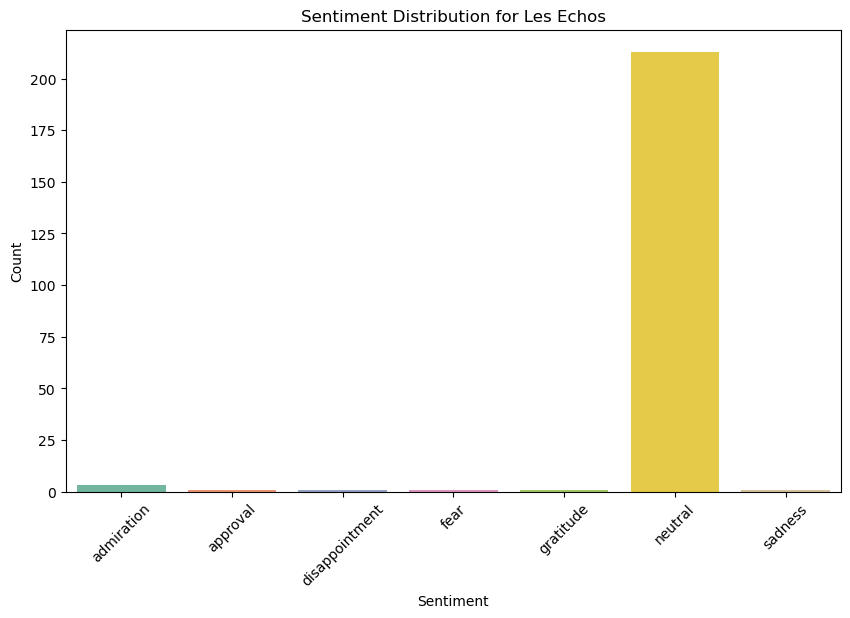

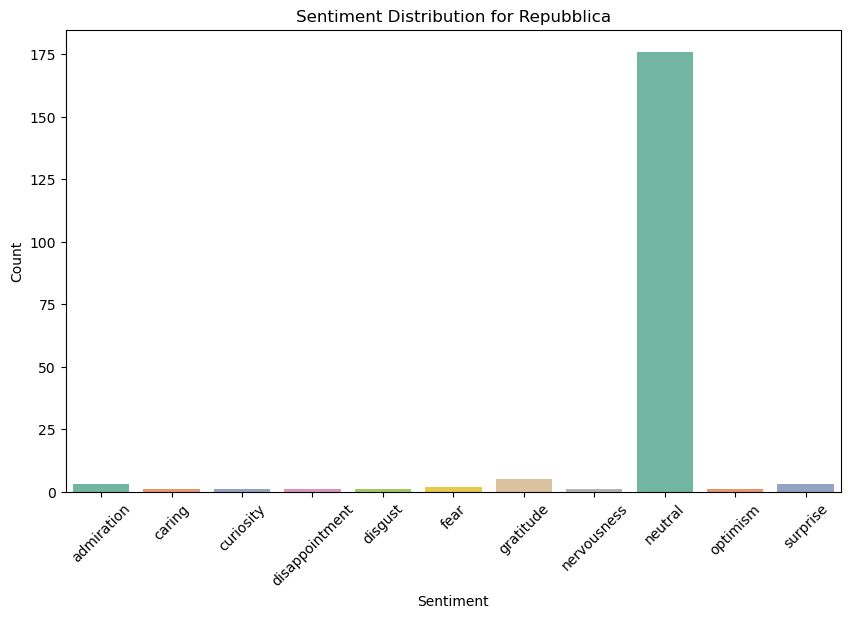

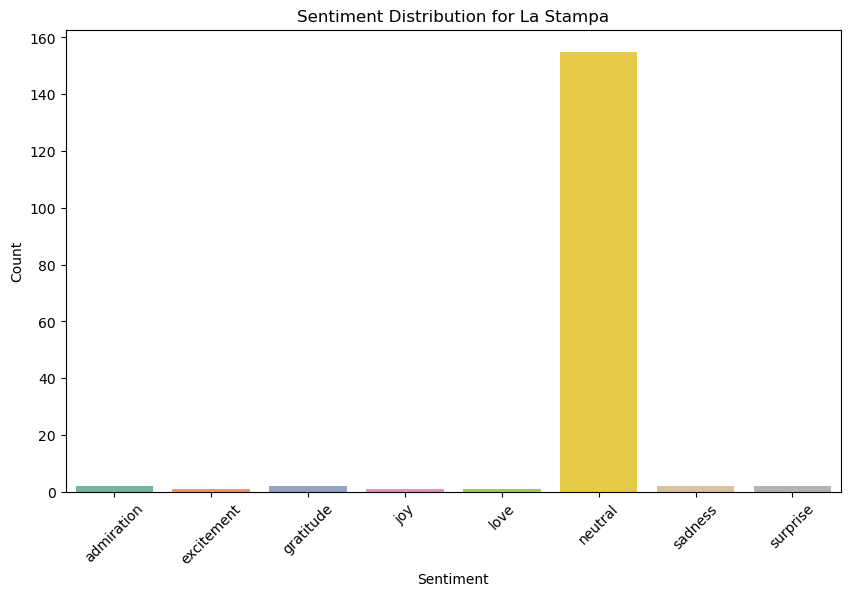

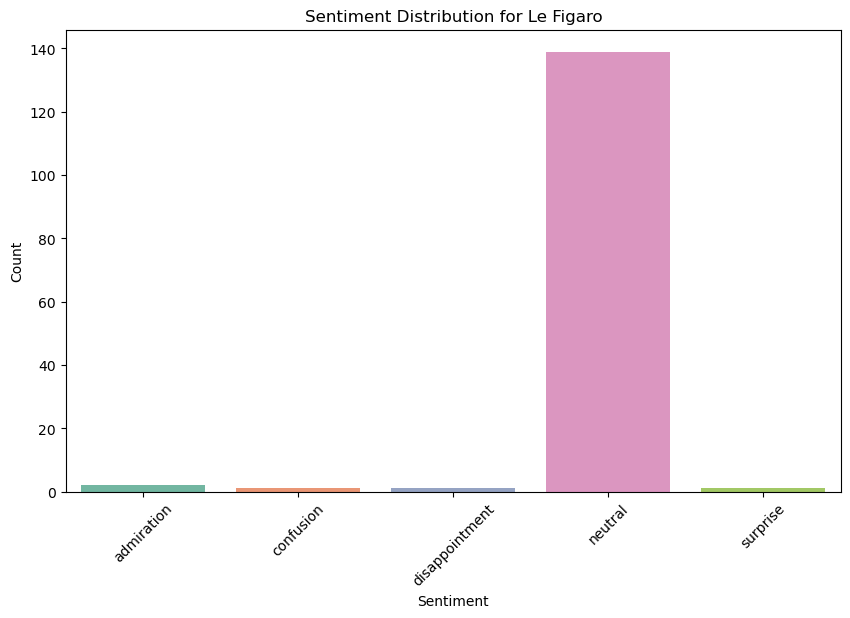

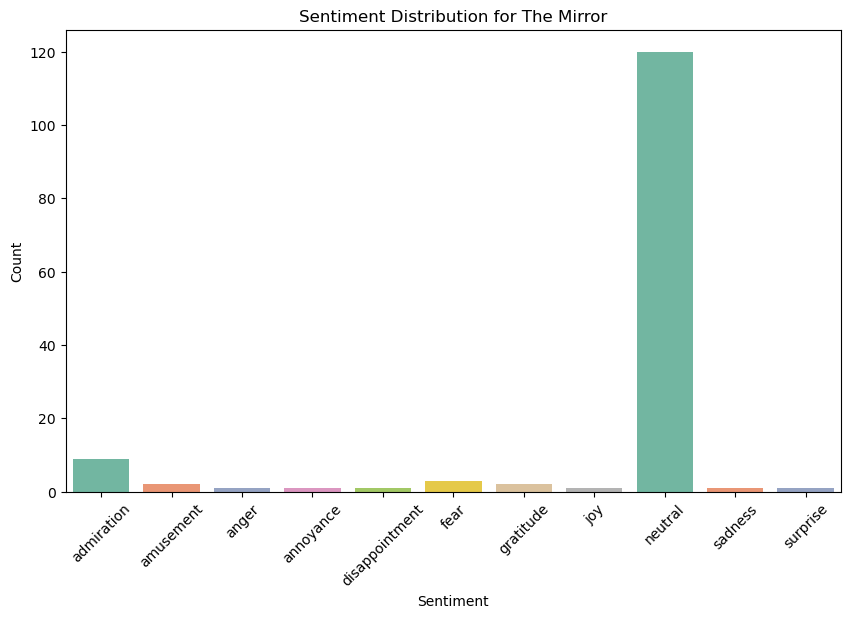

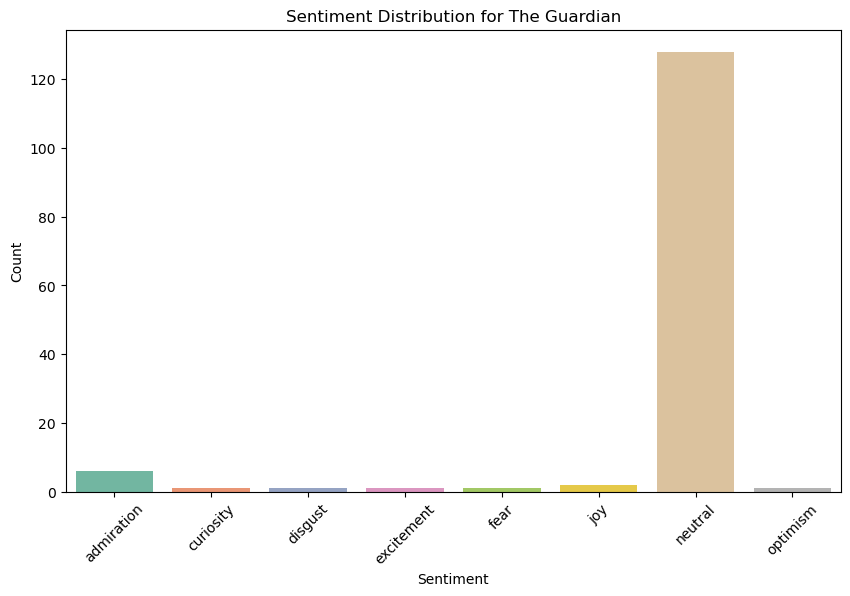

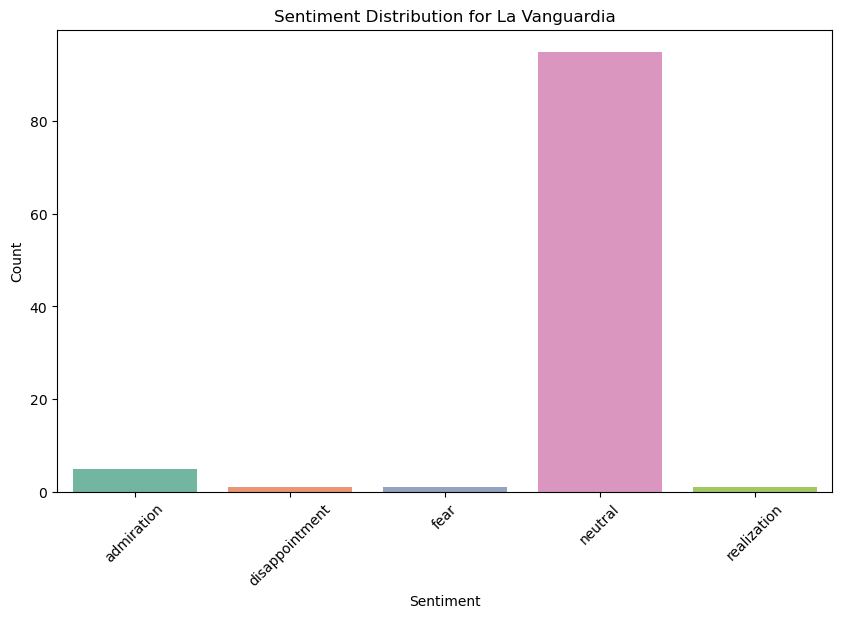

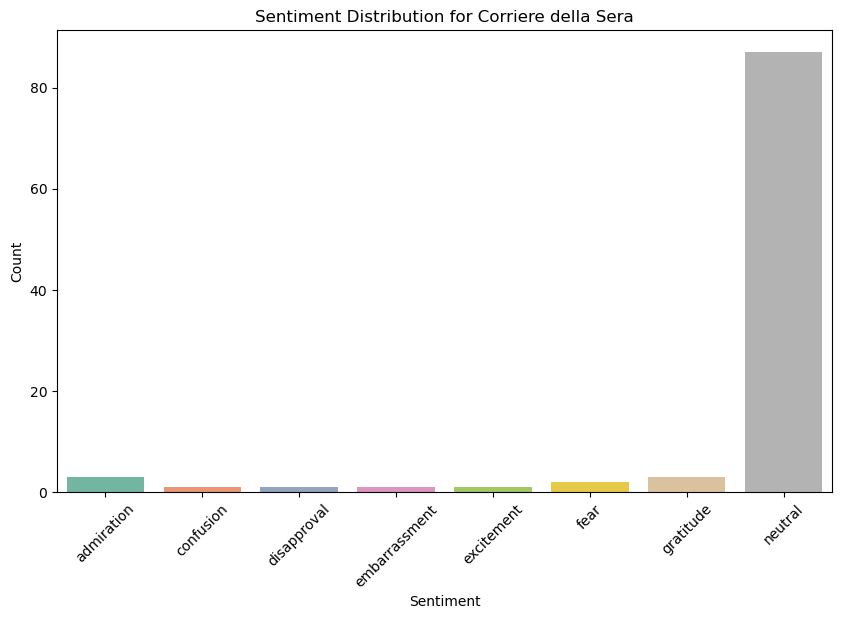

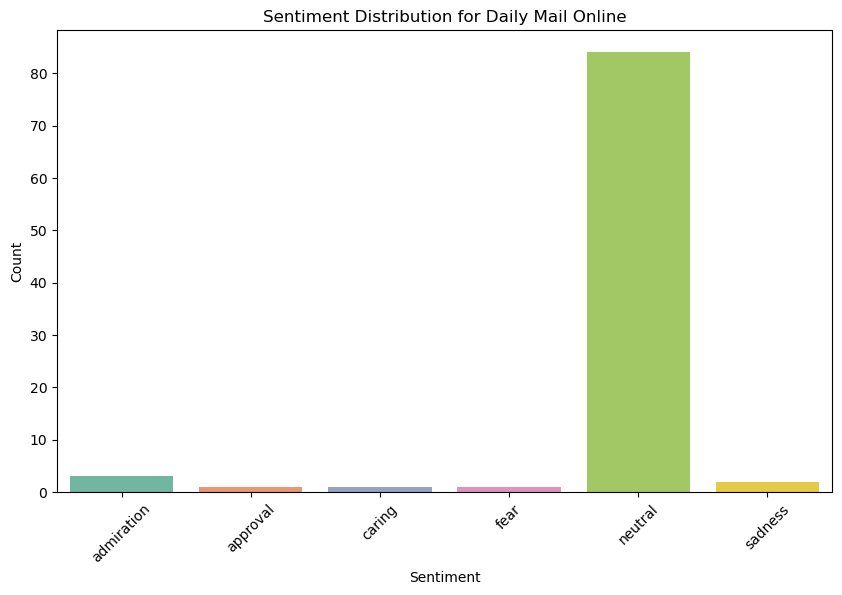

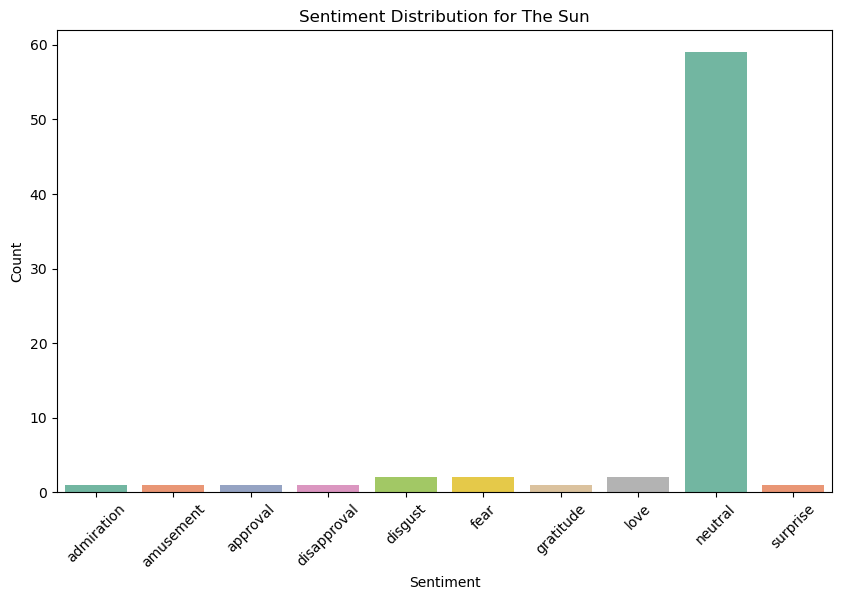

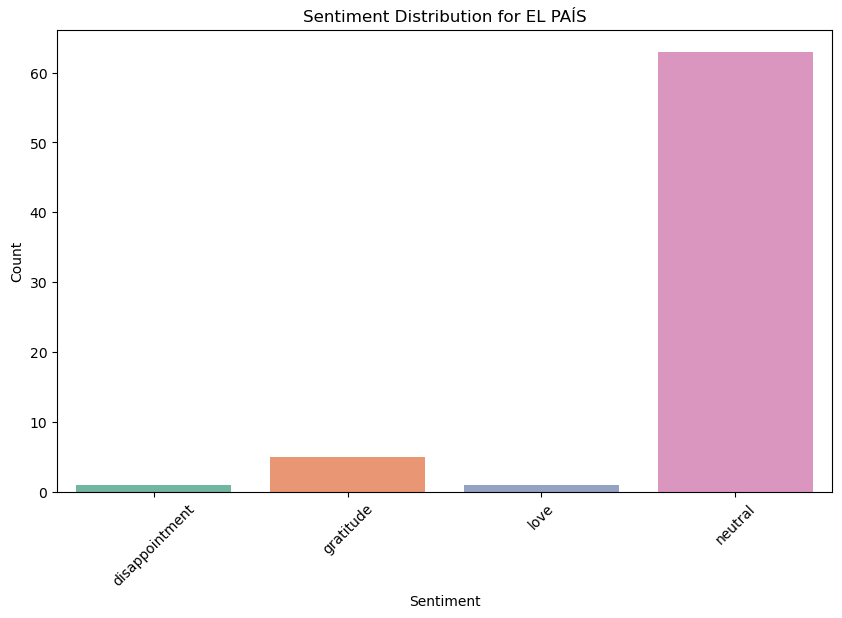

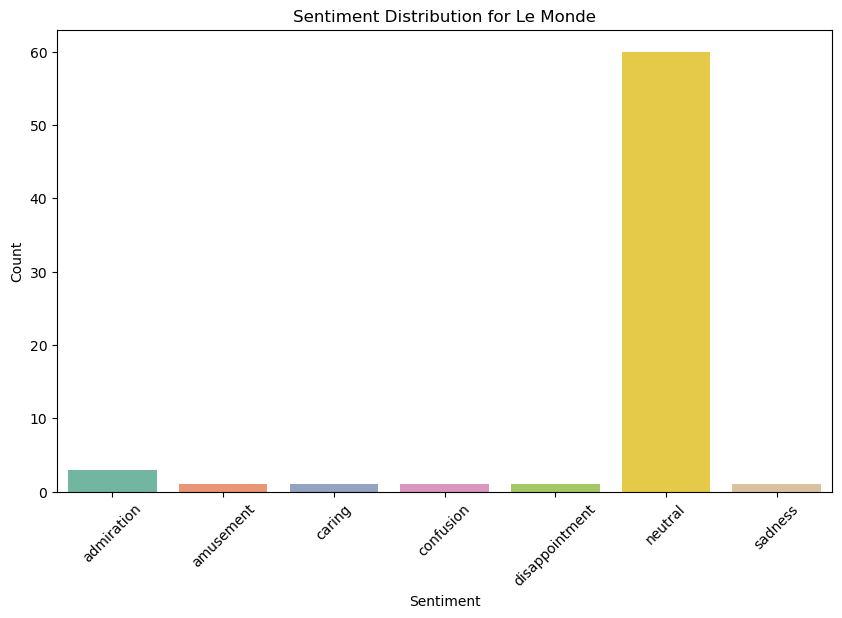

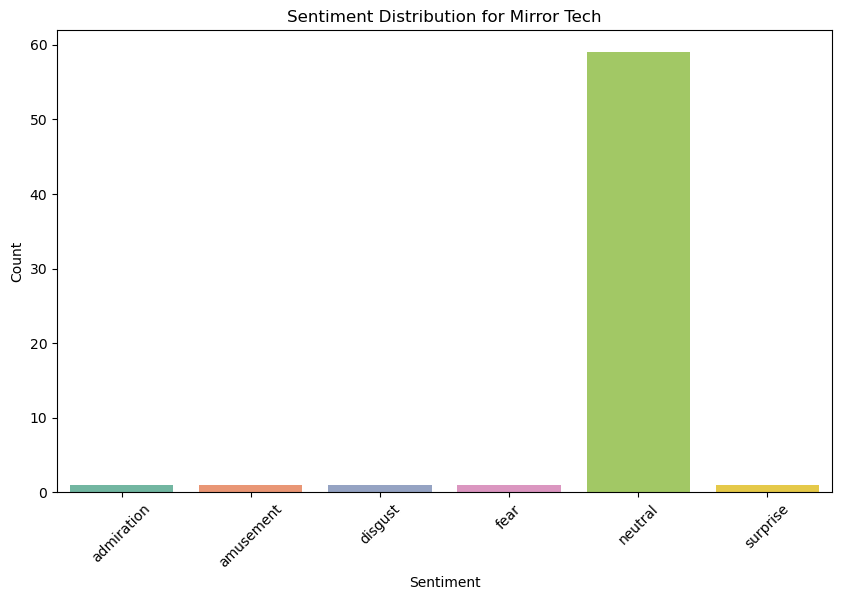

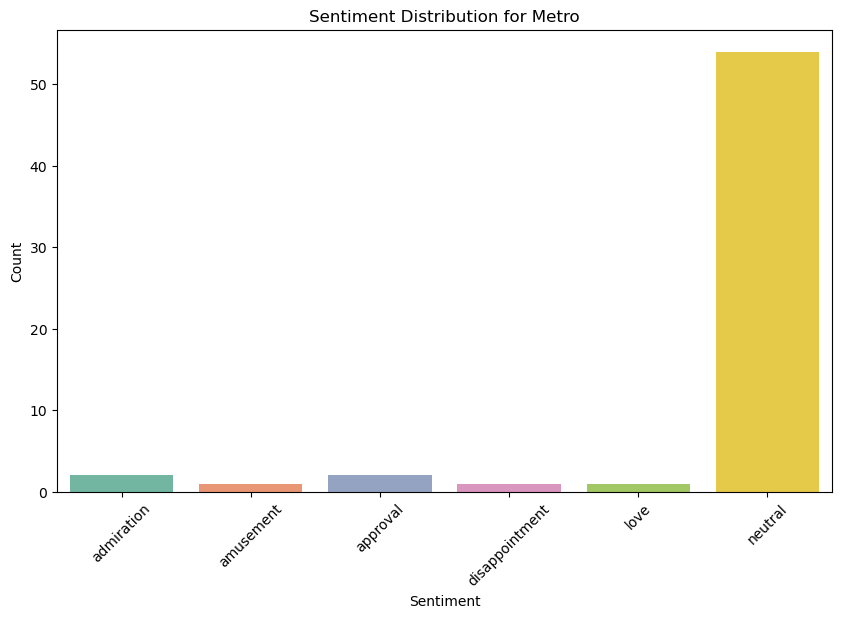

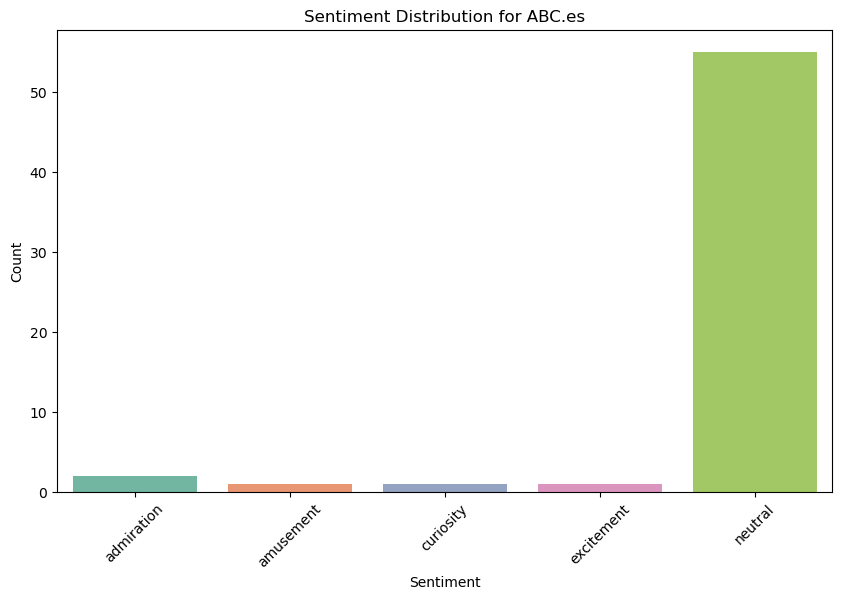

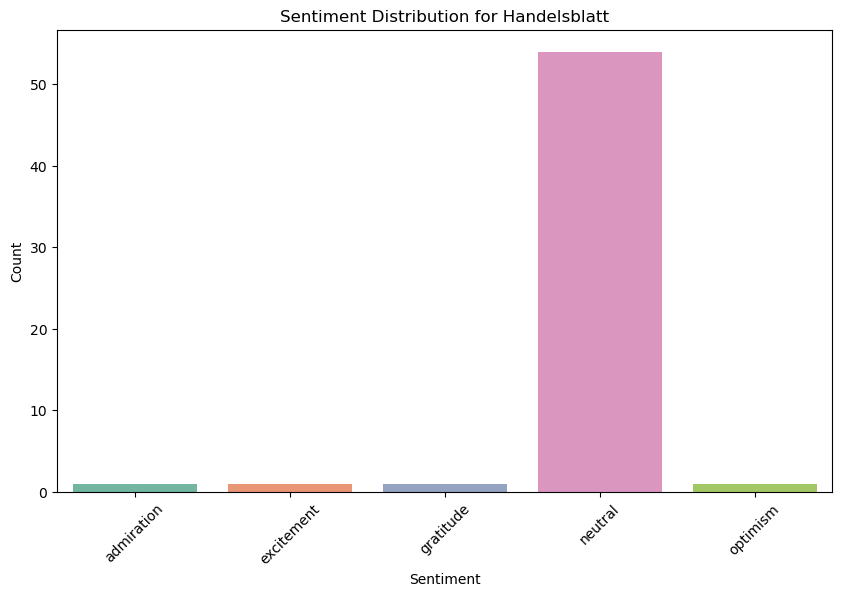

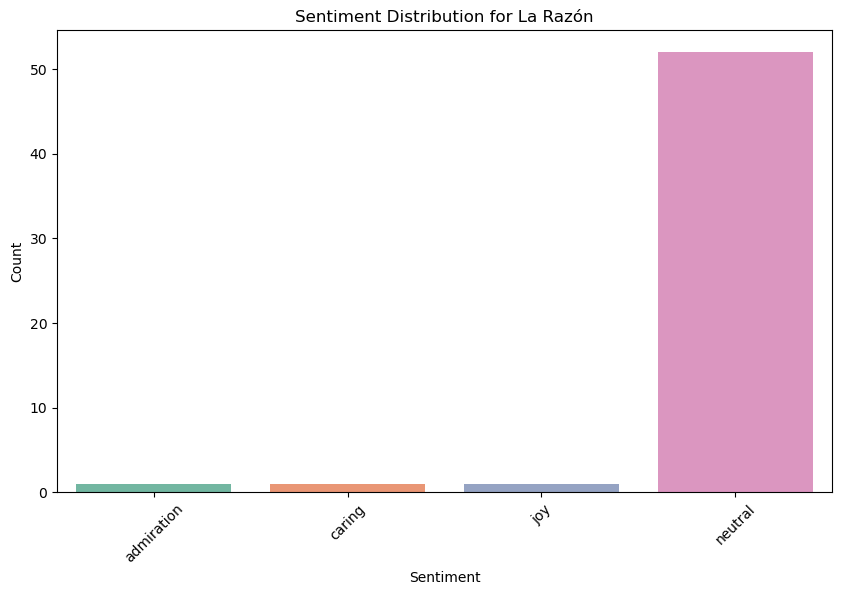

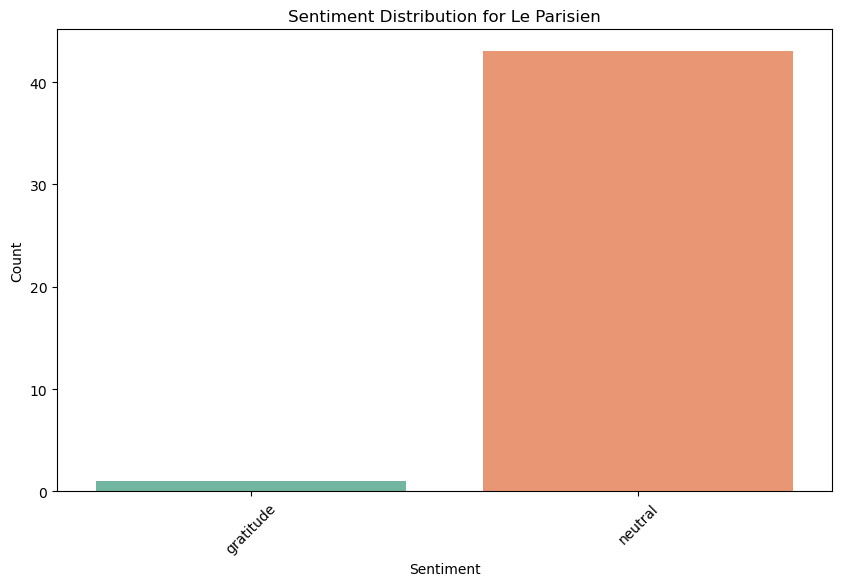

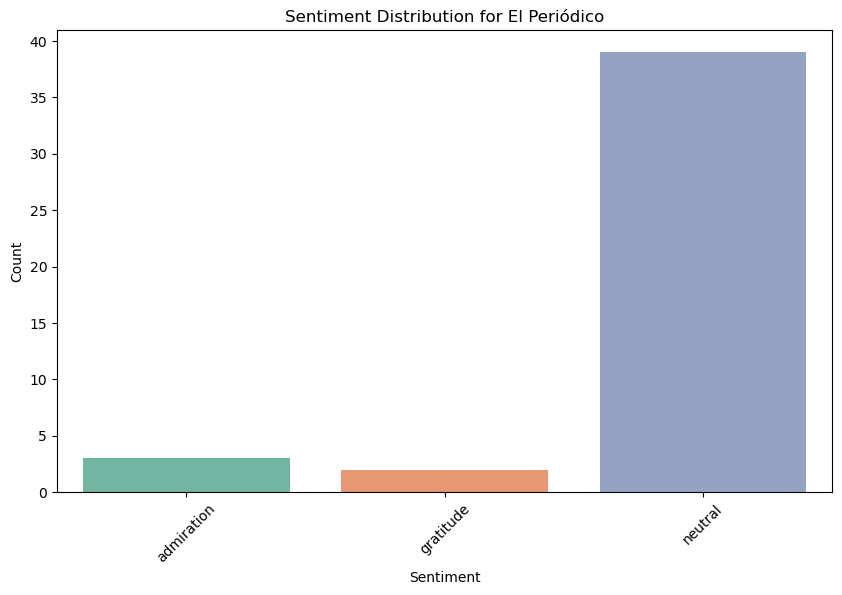

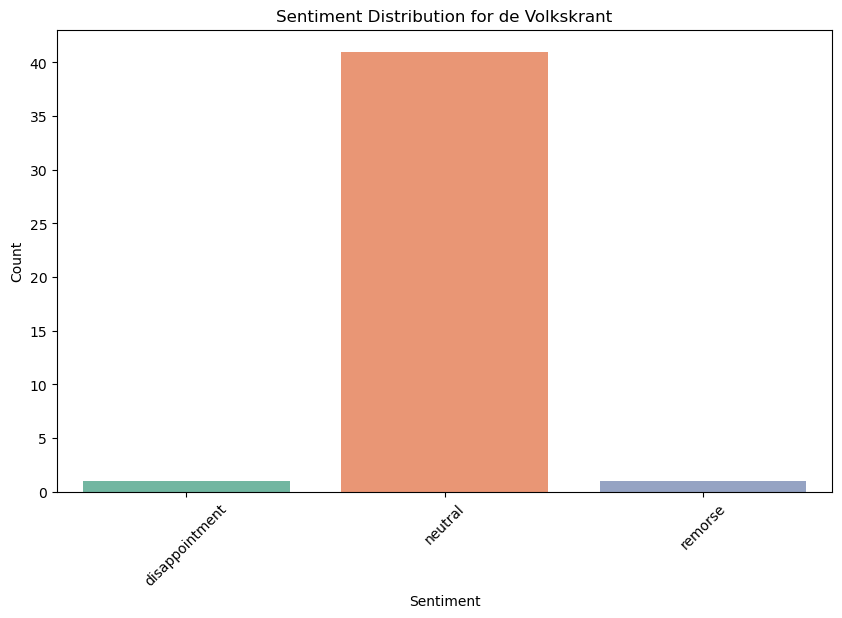

In [17]:
# Load the dataframe csv
df = pd.read_csv('sentiment_df.csv')



# Extract the label without the score
sent = list(df['sentiment'])
sent = [ast.literal_eval(i)['label'] for i in sent]
df['sentiment_label'] = sent



# Extract all the journals that have tweeted something
cited_journals = list(df['author.name'])


# Count the occurrences of each journal in the list
element_counts = Counter(cited_journals)

# Extract the 20 most common journals
most_common_elements = element_counts.most_common(20)


# Extract the unique journals
unique_journals = [i[0] for i in most_common_elements]



grouped_data = df.groupby(['author.name', 'sentiment_label']).size().reset_index(name='Count')


for journal in unique_journals:
    plt.figure(figsize=(10, 6))  # Set the figure size for each barplot
    sns.barplot(data=grouped_data[grouped_data['author.name'] == journal],
                x='sentiment_label', y='Count', palette='Set2')
    plt.title(f'Sentiment Distribution for {journal}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


# Word cloud

In [ ]:
def generate_ngrams(text: str, n: int) -> List[Tuple[str]]: # returns a list of tuples
    """
    Generate n-grams from a given text.
    
    Parameters:
    - text (str): The input text.
    - n (int): The number 'n' in n-gram, indicating the length of the sequence.
    
    Returns:
    - List[Tuple[str]]: A list of n-grams.
    """
    # Tokenize the text into words
    words = text.split()
    
    # Initialize an empty list to store the n-grams
    ngrams = []
    
    # Loop through the words to create n-grams
    for i in range(len(words) - n + 1):
        ngram = tuple(words[i:i+n])
        ngrams.append(ngram)
        
    return ngrams

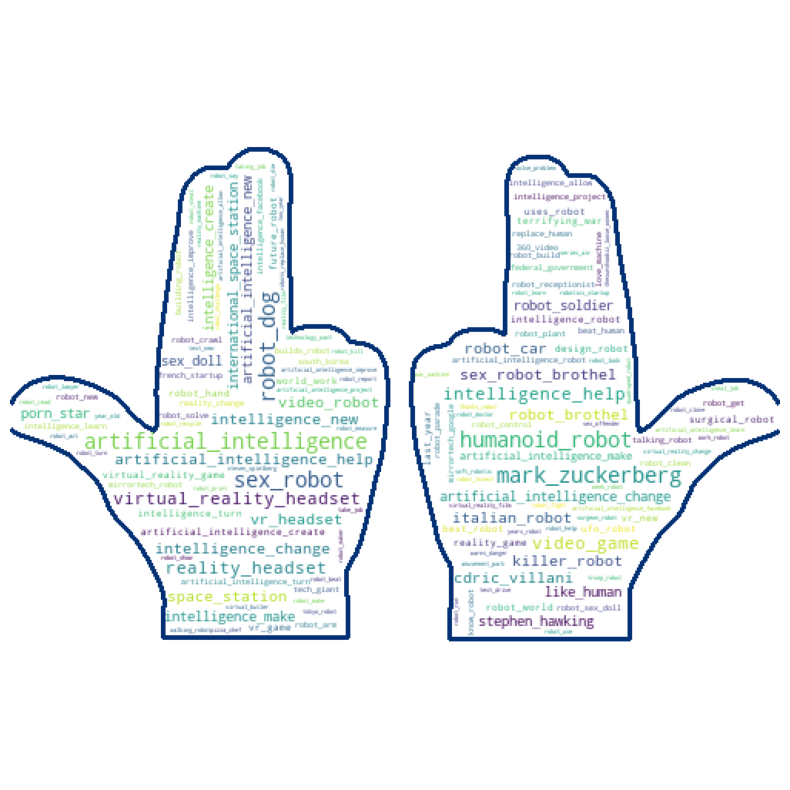

In [ ]:
c_vec = CountVectorizer(ngram_range=(2,3))

# matrix of ngrams
ngrams = c_vec.fit_transform(df['text'])

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
vocab = c_vec.vocabulary_df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], 
                                                        reverse=True)).rename(columns={0: 'frequency', 
                                                                                       1:'bigram/trigram'})

# let's put everything in onle list for our wordcloud!
tweet_string_list = vocab['bigram/trigram'].str.replace(' ','_').tolist()
tweet_string = ' '.join(tweet_string_list)

# create a mask, it will define the shape of the wordcloud
mask_twiter = np.array(Image.open("data/Twitter.png"))
mask_jul = np.array(Image.open("data/Jul.png"))

wordcloud = WordCloud(background_color = 'white', 
                      max_words = 500, 
                      mask=mask_jul, 
                      contour_color='#023075',
                      contour_width=3).generate(tweet_string)
plt.figure(figsize=[10, 10])
plt.imshow(wordcloud)
plt.axis("off")

plt.savefig("data\wordcloud_jul.png")
plt.show()

# Zero-shot classification

Apply MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli to assign a topic to each Tweet.

In [ ]:
# To avoid an error I faced when using pipeline: 

!pip install sentencepiece 

In [ ]:
# https://huggingface.co/MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli/discussions?status=closed
# https://github.com/paulbricman/autocards/issues/35

classifier = pipeline("zero-shot-classification", 
                      model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")

# These labels have been (rapidly) created with my brain when looking at the wordcloud
candidate_labels = ['robot', 'sex', 'video game', 'space', 'virtual reality', 'war', 'artificial intelligence']

df.insert(loc=len(df.columns), column='topics', value=df.progress_apply(lambda x: classifier(x['text'], candidate_labels, multi_label=True), axis=1))

# took 93 minutes to execute!

c:\Users\Jason\anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


  0%|          | 0/2917 [00:00<?, ?it/s]

In [ ]:
# add column 'main_topics' to df

def get_main_topics(row):
    # extract topics with score >= 0.90
    main_topics = [i for i in row['topics']['scores'] if i >= 0.90]

    # get list of topics with score >= 0.90
    main_topics = row['topics']['labels'][:len(main_topics)]

    if len(main_topics) >= 1:
        return main_topics
    
    else:
        return [row['topics']['labels'][0]]
    
df.insert(loc=len(df.columns), column='main_topics', value=df.progress_apply(lambda row: get_main_topics(row), axis=1))

In [ ]:
# add a column with only one topic to see if we get way less topics or not

def get_one_topic(row):
    return row['topics']['labels'][0]

df.insert(loc=len(df.columns), column='one_topic', value=df.progress_apply(lambda row: get_one_topic(row), axis=1))

  0%|          | 0/2917 [00:00<?, ?it/s]

In [ ]:
# save df to .csv

df.to_csv('data/zero_shot_classification.csv', index=False)

In [ ]:
# Open the dataset saved when this notebook has been run for the first time
# (so that you don't need to apply the model to the whole dataset again)

from ast import literal_eval

df = pd.read_csv('data/zero_shot_classification.csv')

df['topics'] = df['topics'].apply(lambda x: literal_eval(x))
df['main_topics'] = df['main_topics'].apply(lambda x: literal_eval(x))

In [ ]:
# count number of times each topic appears (main_topics column)

word_count_main = {'robot': 0, 
              'sex': 0, 
              'video game': 0, 
              'space': 0, 
              'virtual reality': 0, 
              'war': 0, 
              'artificial intelligence': 0}

for row in df['main_topics']:
    for main_topic in row: 
        # row is a list (as several topics can have a score >= 0.90)
        word_count_main[main_topic] += 1

word_count_main

{'robot': 1441,
 'sex': 105,
 'video game': 286,
 'space': 152,
 'virtual reality': 386,
 'war': 67,
 'artificial intelligence': 1757}

In [ ]:
# count number of times each topic appears (one_topic column)

word_count_one = {'robot': 0, 
              'sex': 0, 
              'video game': 0, 
              'space': 0, 
              'virtual reality': 0, 
              'war': 0, 
              'artificial intelligence': 0}

for row in df['one_topic']:
    word_count_one[row] += 1

word_count_one

{'robot': 1197,
 'sex': 48,
 'video game': 190,
 'space': 47,
 'virtual reality': 329,
 'war': 45,
 'artificial intelligence': 1061}

In [ ]:
# sort dict by values
word_count_one = {k: v for k, v in sorted(word_count_one.items(), key=lambda item: item[1], reverse=True)}

fig = px.bar(y=word_count_one.values(), 
              x=word_count_one.keys())
fig.update_layout(plot_bgcolor = "white")
fig.update_layout(
    title="Tweets topics",
    xaxis_title="",
    yaxis_title="Number of occurence",
    font=dict(
         size=12,
        color="Black"
    ),
    plot_bgcolor = "white"
)
fig.write_image('data/topics.png')
fig.show()

In [ ]:
# Install package needed to save plots as .png

!pip install -U kaleido

     ---------------------------------------- 65.9/65.9 MB 1.5 MB/s eta 0:00:00


In [ ]:
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Bar(x=df.loc[(df['label'] == 'en') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).index, 
            y=df.loc[(df['label'] == 'en') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).values,
            name='England'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[(df['label'] == 'fr') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).index, 
            y=df.loc[(df['label'] == 'fr') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).values,
            name='France'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[(df['label'] == 'it') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).index, 
            y=df.loc[(df['label'] == 'it') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).values,
            name='Italy'),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df.loc[(df['label'] == 'es') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).index, 
            y=df.loc[(df['label'] == 'es') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).values,
            name='Spain'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[(df['label'] == 'de') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).index, 
            y=df.loc[(df['label'] == 'de') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).values,
            name='Germany'),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[(df['label'] == 'nl') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).index, 
            y=df.loc[(df['label'] == 'nl') & (df['one_topic'] == 'sex')].groupby('author.name')['id'].count().sort_values(ascending=False).head(5).values,
            name='Netherlands'),
    row=2, col=3
)

fig.update_layout(height=600, width=800, title_text="Top 5 journals with the most Tweets about sex")
fig.write_image('data/top5_sex.png')
fig.show()

In [ ]:
# Check if the dataset is balanced

fig = px.pie(df.groupby('label')['label'].count(), 
             values=df.groupby('label')['label'].count().values, 
             names=df.groupby('label')['label'].count().index, 
             title='Is the dataset balanced?')
fig.update_layout(height=600, width=800)
fig.write_image('data/is_dataset_balanced.png')
fig.show()

In [ ]:
# Take a look at some english Tweets related to sex

for index, row in df.loc[(df['label'] == 'en') & (df['one_topic'] == 'sex')].iterrows():
    print(row['author.name'], ':', row['text'], )

Mirror World News : tescos 10 musthave christmas toys include twerking robot llama hogwarts tower
The Mirror : mirrorweirdnews thanks technology men realistic sex
The Mirror : mirrortech virtualtwerk male sex toy becomes popular removed market
Metro : city wants share photos anyone visits new robot sex brothel online
The Sun : sex robot enthusiast owns five love dolls reveals hes popular women
Evening Standard : could sex robot save marriage canadian professor thinks
Mirror Tech : virtualtwerk male sex toy becomes popular removed market
The Mirror : mirrortech couples record sex sessions relive vr headsets
The Sun : love machine humans soon lose virginity romping sex robots
The Sun : thesunshowbiz loose women stars launch xrated sex robot chat christine lampard insists marriage frank would
Daily Mail Online : one five germans want robot sex doll
Daily Mail Online : sex robots banned says leading robot ethicist
The Mirror : mirrortech sex robot firm unveils transsexual doll vagina detac